# Artificial Neural Networks

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 John von Neumann:</strong> If people do not believe that mathematics is simple, it is only because they do not realise how complicated life is.
</div>

<iframe class="speakerdeck-iframe" frameborder="0" src="https://speakerdeck.com/player/66a1b93a85b143a1861630e7116ae1df" title="Machine Learning for Materials (Lecture 6)" allowfullscreen="true" style="border: 0px; background-clip: padding-box; background-color: rgba(0, 0, 0, 0.1); margin: 0px; padding: 0px; border-radius: 6px; box-shadow: rgba(0, 0, 0, 0.2) 0px 5px 40px; width: 100%; height: auto; aspect-ratio: 560 / 420;" data-ratio="1.3333333333333333"></iframe>

[Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture6-nn)

## 🔬 Learning microstructure

While chemical bonds and the unit cells of crystalline materials are defined at the nanometre scale, morphological features such as grains and voids emerge at the micron scale. How the microscopic building blocks are arranged determines how strong, durable, or conductive a material can be.

Today, we will build our own perceptron model, interact with convolutional filters, and apply a deep learning model to probe the microstructure of materials. 

## From perceptrons to neural networks

The perceptron is a fundamental building block of artificial neural networks. Inspired by the way neurons in the brain work, a perceptron takes multiple inputs, applies weights to each input, sums them up, and passes the result through an activation function to produce an output. It is a binary classifier and can be trained to learn linear decision boundaries for simple classification tasks.

The perceptron function can be represented mathematically as:

$$
f(x) = \begin{cases}
1, & \text{if } \sum_{i=1}^{n} w_i x_i + b > 0 \\
0, & \text{otherwise}
\end{cases}
$$

where:
- $f(x)$ represents the output of the perceptron for input $x$
- $w_i$ are the weights associated with input features $x_i$
- $b$ is the bias term
- $n$ is the number of input features

In [12]:
# Installation of libraries
!pip install scikit-image --quiet
!pip install torchvision --quiet

In [13]:
# Import of modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's start with defining a perceptron function and understanding the input/output behaviour.

In [14]:
# Function to calculate the output of the perceptron with bias
def perceptron(x1, x2, w1, w2, bias):
    weighted_sum = x1 * w1 + x2 * w2 + bias
    return 1 if weighted_sum >= 0 else 0

print("The output for (1,1,1,1,0) is", perceptron(1, 1, 1, 1, 0))
print("The output for (0,0,0,0,-1) is", perceptron(0, 0, 0, 0, -1))
print("The output for (-1,0,1,0,1) is", perceptron(-1, 0, 1, 0, 1))
print("The output for (-1,0,-1,0,-0.5) is", perceptron(-1, 0, -1, 0, -0.5))

The output for (1,1,1,1,0) is 1
The output for (0,0,0,0,-1) is 0
The output for (-1,0,1,0,1) is 1
The output for (-1,0,-1,0,-0.5) is 1


<details>
<summary> Code hint </summary>
You want to define `weighted_sum`, not add it to the inputs!
</details>

Now we can take a look at the decision boundary. Imagine, this could be used to feed in temperature vs pressure and plot a simple binary phase diagram, e.g. solid vs liquid. You can play with the weights to get a feeling for their effect.

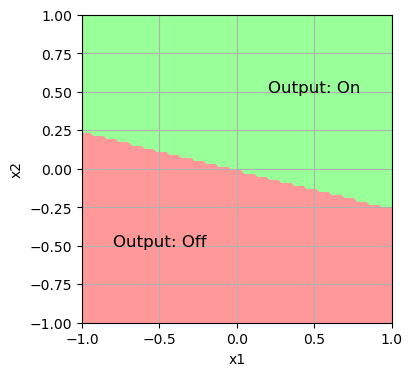

In [15]:
# Plot the perceptron decision boundary
w1, w2 = 1, 4 # weights
bias = 0   # bias term

# Create a grid of x1 and x2 values
x1_values = np.linspace(-1, 1, 100)
x2_values = np.linspace(-1, 1, 100)
x1_grid, x2_grid = np.meshgrid(x1_values, x2_values)

# Calculate perceptron outputs over the grid
output = np.array([
    [perceptron(x1, x2, w1, w2, bias) for x1 in x1_values]
    for x2 in x2_values
])

plt.figure(figsize=(4, 4))
plt.contourf(x1_grid, x2_grid, output, levels=[-0.1, 0.1, 1], colors=["#ff9999", "#99ff99"])
plt.text(-0.5, -0.5, "Output: Off", fontsize=12, color='black', ha='center')
plt.text(0.5, 0.5, "Output: On", fontsize=12, color='black', ha='center')
plt.xlabel('x1'); plt.ylabel('x2')
plt.grid(True); plt.show()

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>🐢 Take a beat:</strong> Experiment with different weights and thresholds! Observe how the decision boundary changes. 
</div>

That was fun, but a lone perceptron is limited in terms of the behaviour it can represent. How could we simulate a more realistic phase diagram for example? Let's code a neural network!

Here the sigmoid activation function will be used, which can be represented mathematically as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

where:
- $\sigma(x)$ is the sigmoid function applied to input $x$
- $e$ is the base of the natural logarithm

The output for (-1) is 0.2689414213699951
The output for (0) is 0.5
The output for (1) is 0.7310585786300049
The output for (10000) is 1.0


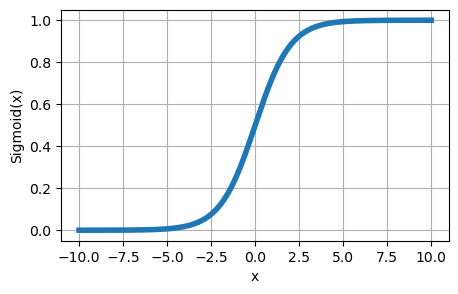

In [16]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print ("The output for (-1) is", sigmoid(-1))
print ("The output for (0) is", sigmoid(0))
print ("The output for (1) is", sigmoid(1))
print ("The output for (10000) is", sigmoid(10000))

# Simple plot
x_values = np.linspace(-10, 10, 400)  # Create 400 points from -10 to 10
y_values = sigmoid(x_values)
plt.figure(figsize=(5, 3))
plt.plot(x_values, y_values, linewidth=4)
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.show()

<details>
<summary> Code hint </summary>
The sigmoid function needs an input, x. You can also trying different input values to get a feeling for how the function works.
</details>

The plot shows how the input values are mapped to a smooth S-shaped curve between 0 and 1. We will use this in the next model (a two-layer neural network) to predict the phase of a material (solid or liquid) based on temperature and pressure. 

In the **hidden layer**, the weighted sum of inputs (`x1` and `x2`) is calculated using weights `w1` and `w2`. This sum is passed through a sigmoid activation function to produce the `hidden_layer_output`.
The **output layer** combines the hidden layer's result with another weighted sum of the inputs (`v1` and `v2`). It then applies a sigmoid activation function to compute the final `output_layer_input`, representing the predicted phase probability.

The resulting pseudo phase diagram maps temperature and pressure to phase probabilities. The orange region corresponds to a solid phase, while the blue region indicates a liquid phase. 

This is a toy model with fixed weights. In practice, frameworks like `pytorch` are used to train neural networks on large, labelled datasets.

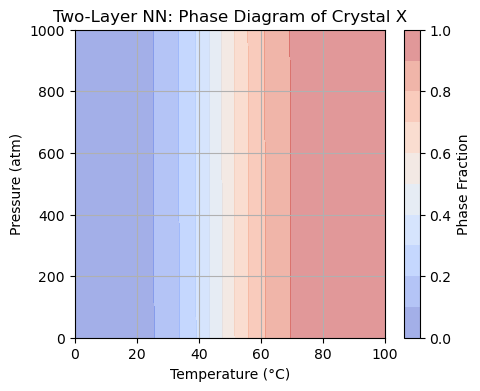

In [17]:
# Phase transition model

# Function to scale data between -1 and 1
def scale_data(data, min_val, max_val):
    return 2 * (data - min_val) / (max_val - min_val) - 1

# Function to calculate the output of the two-layer neural network
def neural_network(x1, x2, w1, w2, v1, v2):
    hidden_layer_input = x1 * w1 + x2 * w2
    hidden_layer_output = sigmoid(hidden_layer_input)
    output_layer_input = hidden_layer_output * v1 + x2 * v2
    return sigmoid(output_layer_input)

# Temperature and pressure range
temperature_range = np.linspace(0, 100, 100)  # Temperature in Celsius
pressure_range = np.linspace(0, 1000, 100)    # Pressure in atm

# Scale the temperature and pressure to [-1, 1]
scaled_temperature = scale_data(temperature_range, min(temperature_range), max(temperature_range))
scaled_pressure = scale_data(pressure_range, min(pressure_range), max(pressure_range))

# Assign weights for the input and hidden layers
# (in a real model, these would be learned from data)
w1 = 0.1
w2 = -0.1
v1 = 0.5
v2 = 5

# Create data points for visualisation
X1, X2 = np.meshgrid(scaled_temperature, scaled_pressure)
predicted_phases = np.zeros_like(X1)

# Apply the neural network to predict phases
for i in range(len(scaled_temperature)):
    for j in range(len(scaled_pressure)):
        predicted_phases[i, j] = neural_network(scaled_temperature[i], scaled_pressure[j], w1, w2, v1, v2)

# Plot the "phase diagram"
plt.figure(figsize=(5, 4))
plt.contourf(temperature_range, pressure_range, predicted_phases, alpha=0.5, levels=np.linspace(0, 1, 11), cmap='coolwarm')
plt.colorbar(label='Phase Fraction')
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (atm)')
plt.title('Two-Layer NN: Phase Diagram of Crystal X')
plt.grid(True)
plt.show()

## Image processing

Many characterisation techniques in materials science produce image data. Researchers can save time and perform advanced experiments (e.g. active learning) and analysis (e.g. feature identification) using code. While "point and click" software solutions exist for image processing, they are often expensive and difficult to customise and automate for large datasets.

Let's start by considering three classical convolutional filters:

1. **Gaussian**
   - Smoothes an image by reducing noise.
   - Blurs the image by applying a weighted average to pixels.
   - Kernel:
     ```
     1  2  1
     2  4  2
     1  2  1
     ```

2. **Sobel**
   - Highlights edges and contours in an image.
   - Computes gradient magnitude using convolutional kernels.
   - Sobel Horizontal Kernel:
     ```
     -1  0  1
     -2  0  2
     -1  0  1
     ```
   - Sobel Vertical Kernel:
     ```
     -1 -2 -1
      0  0  0
      1  2  1
     ```
     
3. **Laplacian**
   - Emphasizes rapid intensity changes (edges).
   - Calculates the second derivative to highlight inflection points.
   - Laplacian Kernel:
     ```
      0  1  0
      1 -4  1
      0  1  0
     ```

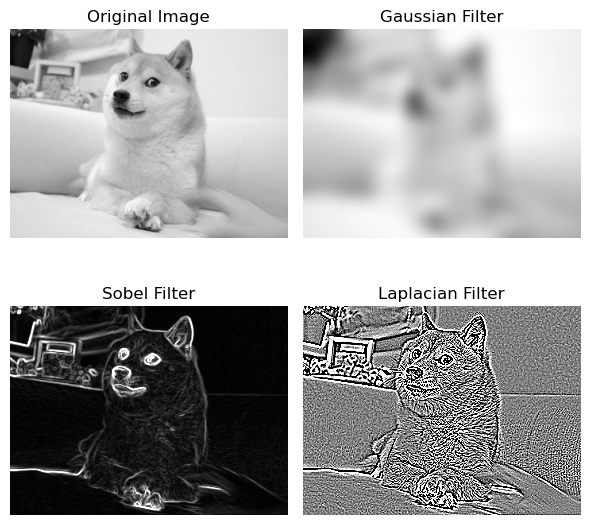

In [18]:
from skimage import io, color, filters

# Load an example image (you can replace this with your own)
#image_url = "https://upload.wikimedia.org/wikipedia/commons/5/5e/AlubronzeCuAl20v500.png"
image_url = "https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg"
image = io.imread(image_url)
gray_image = color.rgb2gray(image)

# Apply classical image filters
gaussian_filtered = filters.gaussian(gray_image, sigma=10.0)
sobel_filtered = filters.sobel(gray_image)
laplacian_filtered = filters.laplace(gray_image)

# Plot the original and filtered images
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(gaussian_filtered, cmap='gray')
plt.title('Gaussian Filter')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(sobel_filtered, cmap='gray', vmin=0, vmax=0.2)  # Adjust vmin and vmax as needed
plt.title('Sobel Filter')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(laplacian_filtered, cmap='gray', vmin=-0.02, vmax=0.02)  # Adjust vmin and vmax as needed
plt.title('Laplacian Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

<details>
<summary> Code hint </summary>
You can add your own image link and see the result.
</details>

### Custom convolutional filters

We are not limited to using pre-built kernels. This code allows you to chose your own kernel matrix and includes an option for repeated convolutions, so you can apply the filter multiple times.

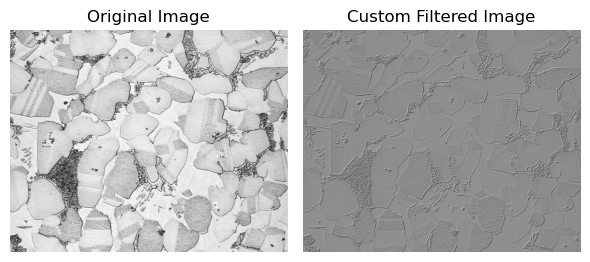

In [19]:
from scipy.ndimage import convolve

# Load an example image (you can replace this with your own image)
image_url = "https://upload.wikimedia.org/wikipedia/commons/5/5e/AlubronzeCuAl20v500.png"
#image_url = "https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg"
image = io.imread(image_url)
gray_image = color.rgb2gray(image)

# Define a larger custom kernel for more noticeable effect
custom_kernel = np.array([[-2, -1, 0],
                          [-1, 1, 1],
                          [0, 1, 2]])

# Normalise the kernel to sum to 1
custom_kernel = custom_kernel / np.sum(custom_kernel)

# Apply custom kernel using convolution
num_iterations = 1 # Number of times to apply the convolution

custom_filtered = gray_image.copy()
for _ in range(num_iterations):
    custom_filtered = convolve(custom_filtered, custom_kernel)

# Plot the original and filtered images
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(custom_filtered, cmap='gray')
plt.title('Custom Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

<details>
<summary> Code hint </summary>
Adjust the kernel and the number of interations that the kernel is applied (`num_iterations`).   
</details>

## Convolutional Neural Networks (CNNs)

CNNs are a class of deep learning models designed for image analysis. We will now build a basic CNN architecture using the deep learning tool `pytorch`.

We all know that scientists like to dress well 🧑‍🔬. Let's make use of the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset that consists of a training set of 60,000 examples and a test set of 10,000 examples of clothing and accessories.

### Fashionable CNN 

Pay attention to each of the steps involved in building the model.

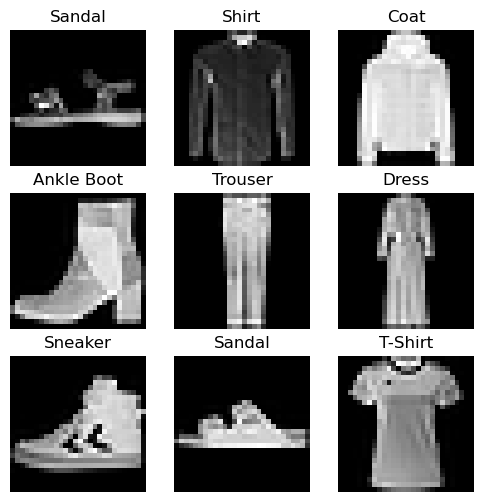

In [20]:
import torch  # PyTorch deep learning library
import torch.nn as nn  # Neural network modules in PyTorch
import torch.optim as optim  # Optimisation algorithms in PyTorch
from torch.utils.data import Dataset, DataLoader  # PyTorch data loading utilities
from torchvision import datasets  # Datasets for computer vision tasks
from torchvision.transforms import ToTensor  # Image transformations in PyTorch

# Step 1 - Data

# Training set
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Test set
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# FashionMNIST labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plot a few examples
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Let's see if the model can classify unseen images. Don't set your hopes too high!

In [21]:
# Step 2 - Model

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()  # ReLU activation function
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()  # ReLU activation function
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        # Flatten the output for the fully connected layers
        self.flatten = nn.Flatten()

        # First Fully Connected Layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()  # ReLU activation function

        # Second Fully Connected Layer (Output Layer)
        self.fc2 = nn.Linear(128, 10)  # 10 output neurons for the 10 classes

    def forward(self, x):
        # Forward pass through the network

        # First Convolutional Layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the output for the fully connected layers
        x = self.flatten(x)

        # First Fully Connected Layer
        x = self.fc1(x)
        x = self.relu3(x)

        # Second Fully Connected Layer (Output Layer)
        x = self.fc2(x)

        return x  # Return the output

<details>
<summary> Code hint </summary>
Your are defining a class, whereas Clas is a popular name in Sweden 🇸🇪</details>

In [22]:
# Step 3 - Train and Test

# Note, this may take a couple of minutes to complete. 
# As you wait, you can pay attention to how the loss improves in time.

# Instantiate the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create DataLoader for training and testing datasets
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item()}")

# Test the model
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Epoch 1/1, Batch 0/938, Loss: 2.2943925857543945
Epoch 1/1, Batch 100/938, Loss: 0.5924073457717896
Epoch 1/1, Batch 200/938, Loss: 0.5006527900695801
Epoch 1/1, Batch 300/938, Loss: 0.4982554018497467
Epoch 1/1, Batch 400/938, Loss: 0.49564027786254883
Epoch 1/1, Batch 500/938, Loss: 0.33699098229408264
Epoch 1/1, Batch 600/938, Loss: 0.39390259981155396
Epoch 1/1, Batch 700/938, Loss: 0.263579398393631
Epoch 1/1, Batch 800/938, Loss: 0.2705289125442505
Epoch 1/1, Batch 900/938, Loss: 0.3218342363834381
Accuracy on the test set: 87.51%


<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>🙋 Training output explained:</strong><br>
    • <strong>Epoch:</strong> The iteration over the entire dataset.<br>
    • <strong>Batch:</strong> The subset of data being processed.<br>
    • <strong>Loss:</strong> Indicates how well the model is performing (lower is better).
</div>

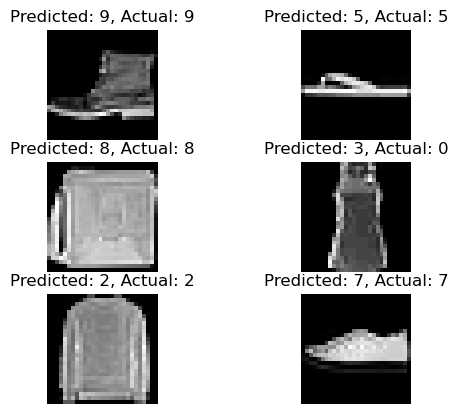

In [23]:
# Function to display images with their predicted and actual labels
def show_predictions(model, dataloader, num_images=5):
    model.eval()
    images, predictions, targets = [], [], []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            images.append(data.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            targets.append(target.cpu().numpy())

    images = np.concatenate(images)
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    # Plot random predictions
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(6, 10))
    for i, index in enumerate(indices, 1):
        plt.subplot(num_images, 2, i)
        plt.imshow(images[index][0], cmap='gray')
        plt.title(f"Predicted: {predictions[index]}, Actual: {targets[index]}")
        plt.axis('off')

    plt.show()

# Show predictions on the test set
show_predictions(model, test_dataloader, num_images=6)

Did it perform well? Remember the labels were:
```
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
```

### Learned filters

We can analyse the filters that were learned for the trained model. These can add some interpretibility for larger image models with insights into the important edges, textures, and patterns that become more complex for deeper layers.

Filter 1 weights:
[[ 0.28907612 -0.18589869 -0.10697722]
 [ 0.17991047  0.3346459  -0.25468218]
 [ 0.15242039 -0.2127904  -0.10645435]]

Filter 2 weights:
[[-0.16965291 -0.13169374 -0.22142565]
 [-0.18096474 -0.32139215  0.3582347 ]
 [-0.00271484  0.4367856  -0.13182895]]

Filter 3 weights:
[[ 0.01985033  0.20589676 -0.05133985]
 [-0.0791447  -0.2620779   0.3207173 ]
 [-0.09938621 -0.44837558 -0.17753811]]

Filter 4 weights:
[[ 0.03296265 -0.20499747  0.23511918]
 [ 0.19521673 -0.01184223  0.07256968]
 [ 0.00181622  0.29991734 -0.04699029]]



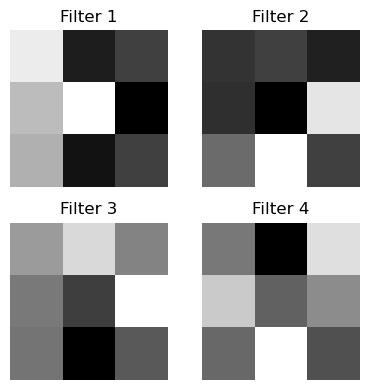

In [24]:
# Get the weights of the first convolutional layer
conv1_weights = model.conv1.weight.data.cpu()

# Visualise learned filters
plt.figure(figsize=(4, 4))
for i in range(4):  # Only the first four filters
    plt.subplot(2, 2, i + 1)

    # Plot the image representation of the filter
    filter_image = conv1_weights[i].numpy()[0]
    plt.imshow(filter_image, cmap="gray")
    plt.axis("off")
    plt.title(f"Filter {i + 1}")

    # Display the matrix representation of the filter
    print(f"Filter {i + 1} weights:")
    print(conv1_weights[i][0].numpy())
    print()

plt.tight_layout()
plt.show()

## Synthetic microscopy data

For the exercise, we will simulate our own characterisation data for training. Think of a spatially varying composition or structure that you could measure with techniques such as energy-dispersive X-ray spectroscopy (EDS) or electron diffraction. Use your imagination!

This spatial map is represented by a 50x50 grid of pixels. To make it interesting, our experimentals failed in 20% of cases, leaving us with some unknown (missing) pixels (0 values).

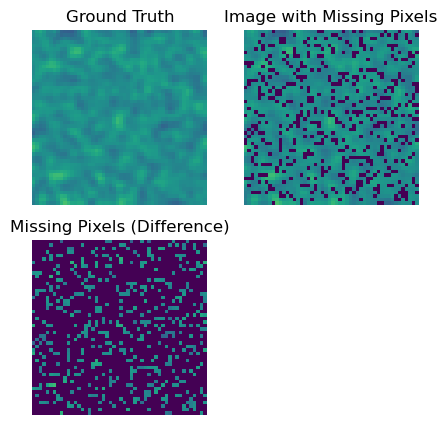

In [25]:
from scipy.ndimage import gaussian_filter  # Gaussian filter for image processing

# Set image size and missing ratio
image_size = (50, 50)  # 50x50 pixels
missing_ratio = 0.20   # % missing pixels

def generate_image_with_missing_pixels(image_size, mean=128, std=50):
    
    # Generate pixel values from a normal distribution
    image_raw = np.random.normal(mean, std, size=image_size).astype(np.uint8)
    # Apply Gaussian filter to mimic short-range order
    sigma = 1  # standard deviation of the filter
    image = gaussian_filter(image_raw, sigma=sigma)
    # Clip values to ensure they are within the valid range [1, 255]
    image = np.clip(image, 1, 255)
    ground_truth = image.copy()
    # Calculate the number of missing pixels
    num_missing_pixels = int(image_size[0] * image_size[1] * missing_ratio)
    # Generate random pixel coordinates for missing pixels
    missing_indices = np.random.choice(image_size[0] * image_size[1], size=num_missing_pixels, replace=False)
    # Set the missing pixels to black (0)
    image_flat = image.reshape(-1)  # Flatten the image
    image_flat[missing_indices] = 0
    # Reshape the image back to the original shape
    image = image_flat.reshape(image_size)

    return image, ground_truth

# Generate an example using the generate_image function
sample_image, ground_truth = generate_image_with_missing_pixels(image_size)

# Display the original image, image with missing pixels, and ground truth
plt.figure(figsize=(5, 5))

plt.subplot(2, 2, 1)
plt.imshow(ground_truth, vmin=0, vmax=255)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(sample_image, vmin=0, vmax=255)
plt.title('Image with Missing Pixels')
plt.axis('off')

plt.subplot(2, 2, 3)
missing_pixels = ground_truth - sample_image
plt.imshow(missing_pixels, vmin=0, vmax=255)
plt.title('Missing Pixels (Difference)')
plt.axis('off')

plt.show()

## 🚨 Exercise 6

<div style="background-color: #dceefb; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>💡 Coding exercises:</strong> The exercises are designed to apply what you have learned with room for creativity. It is fine to discuss solutions with your classmates, but the actual code should not be directly copied.
</div>

### Your details

In [26]:
import numpy as np

# Insert your values
Name = "Your name"
CID = 123446 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: 0" + str(CID) + "]")

This is the work of Your name [CID: 0123446]


### Problem

There are many model parameters to consider when building neural network models.

Two tasks will be given in class related to optimisation of this neural network that can predict the missing values (representing the local property) for each input image. The regression model involves four stages:

1. **Data generation**: Our synthetic dataset of 50x50 pixel images and their corresponding labels (ground truth).

2. **Model creation**: A simple CNN in PyTorch, responsible for predicting the missing values.

3. **Training**: Minimise the (MSE) loss between the predicted and the ground truth values.

4. **Evaluation**: Evaluate the model's performance on an unseen test image.

Learning rate = 0.1
Epoch [5/5] Loss: 0.0009
Learning rate = 0.2
Epoch [5/5] Loss: 0.0006
Learning rate = 0.3
Epoch [5/5] Loss: 0.0005
Learning rate = 0.4
Epoch [5/5] Loss: 0.0005
Learning rate = 0.5
Epoch [5/5] Loss: 0.0006
Learning rate = 0.6
Epoch [5/5] Loss: 0.0006
Learning rate = 0.7
Epoch [5/5] Loss: 0.0008
Learning rate = 0.8
Epoch [5/5] Loss: 0.0016
Learning rate = 0.9
Epoch [5/5] Loss: 0.0040


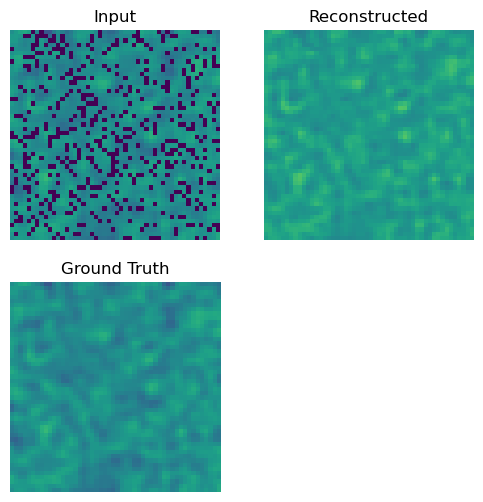

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(102)
np.random.seed(102)

# Generate 500 training image pairs (missing pixels and ground truth)
num_images = 500 
image_pairs = [generate_image_with_missing_pixels(image_size) for _ in range(num_images)]

# Convert images to PyTorch tensors, normalise inputs
images_with_missing_pixels = [torch.from_numpy(image[0]).unsqueeze(0).unsqueeze(0).float() / 255.0 for image in image_pairs]
ground_truth_images = [torch.from_numpy(image[1]).unsqueeze(0).unsqueeze(0).float() / 255.0 for image in image_pairs]

# Simple CNN model
class PixelPredictionModel(nn.Module):
    def __init__(self):
        super(PixelPredictionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

# Initialise model, define loss and optimiser
model = PixelPredictionModel()
criterion = nn.MSELoss()


# Training loop
num_epochs = 5
learning_rate = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
for lr in learning_rate:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for image, ground_truth in zip(images_with_missing_pixels, ground_truth_images):
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, ground_truth)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    print("Learning rate = " + str(lr))
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss / len(images_with_missing_pixels):.4f}')

# Test the model with a sample image
sample_image, ground_truth = generate_image_with_missing_pixels(image_size)
sample_image_tensor = torch.from_numpy(sample_image).unsqueeze(0).unsqueeze(0).float() / 255.0
reconstructed_image = model(sample_image_tensor).squeeze().detach().numpy() * 255.0

# Display original, reconstructed, and ground truth images
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(sample_image, vmin=0, vmax=255)
plt.title('Input')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_image, vmin=0, vmax=255)
plt.title('Reconstructed')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(ground_truth, vmin=0, vmax=255)
plt.title('Ground Truth')
plt.axis('off')

plt.show()

In [28]:
#Empty block for your answers




In [29]:
#Empty block for your answers




<details>
<summary> Task hint </summary>
One approach is to set `lr=rate` and loop over several values of the variable `rate`
</details>

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>📓 Submission:</strong> When your notebook is complete in Google Colab, go to <em>File > Download</em> and choose <code>.ipynb</code>. The completed file should be uploaded to Blackboard under assignments for MATE70026.
</div>

## 🌊 Dive deeper

* _Level 1:_ Tackle Chapter 13 on Neural Networks in [Machine Learning Refined](https://github.com/jermwatt/machine_learning_refined#what-is-new-in-the-second-edition).

* _Level 2:_ Watch [What is a Neural Net](https://www.youtube.com/watch?v=aircAruvnKk) video by 3Blue1Brown.

* _Level 3:_ Cutting edge chapters and examples in [Understanding Deep Learning](https://udlbook.github.io/udlbook).